This notebook explores the network features in the AmazonCN dataset.

In [12]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.utils import get_laplacian
from time import perf_counter
import datetime
import pandas as pd
import networkx as nx
from community import community_louvain
from time import perf_counter

In [4]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from utils.config_utils import load_config
config = load_config()

In [ ]:
def print_graph_info(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Is directed: {G.is_directed()}")
    print(f"Is connected: {nx.is_connected(G)}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print("===== Attributes of the First 10 Nodes =====")
    for i, (node, attributes) in enumerate(G.nodes(data=True)):
        if i < 3:
            print(f"Node {node}:")
            for attr, value in attributes.items():
                print(f"  {attr}: {value}")
            print("-" * 10)  # Separator line for readability
        else:
            break

def augment_feature(nx_G):
    print("===== 1. The modularity-based feature augmentation. =====")
    partition = community_louvain.best_partition(nx_G)
    modularity = community_louvain.modularity(partition, nx_G)
    print(f"the modularity of community is {modularity}") #this gives the modularity of the whole graph
    for community in set(partition.values()):
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        subgraph = nx_G.subgraph(nodes_in_community)
        # print(subgraph)
        community_partition = {node: community for node in nodes_in_community}
        community_modularity = community_louvain.modularity({**partition, **community_partition}, nx_G)
        for node in nodes_in_community:
            nx_G.nodes[node]['modularity'] = community_modularity

    # kcore based 
    print("===== 2. The k-core-based feature augmentation. =====")
    core_numbers = nx.core_number(nx_G)
    #print the max core number
    print(f"the max core number is {max(core_numbers.values())}")
    for node,core in core_numbers.items():
        nx_G.nodes[node]['core'] = core
    return nx_G
    
class GraphData:
    def __init__(self):
        self.nx_G = None
        self.adj = None
        self.features = None
        self.labels = None

        network_path = os.path.join(config['data']['path'], config['data']['network_file'])
        features_path = os.path.join(config['data']['path'], config['data']['feature_file'])
        labels_path = os.path.join(config['data']['path'], config['data']['label_file'])

        ## load network
        print("start loading J01Network")
        graph_data = np.loadtxt(network_path, delimiter=' ', dtype=int) #graph_data is a numpy array
        graph_data[:,0] = graph_data[:,0] - 1
        graph_data[:,1] = graph_data[:,1] - 1 # 0-based index, the stored txt is a 1-based index edge list
        self.nx_G = nx.Graph() # create a new graph
        self.nx_G.add_edges_from(graph_data) # add edges to the graph
        #suumary of the network
        print("J01Network summary:")
        print_graph_info(self.nx_G)

        #construct the adjacency matrix
        edge_tensor = torch.from_numpy(graph_data).long() #input is a numpy array of edges, this step transfer the numpy array to tensor
        indices = edge_tensor.t().contiguous() #transpose the edge_tensor and make it contiguous, this is to make the edge_tensor to be a 2D tensor where each column is an edge, we then use this tensor to construct the sparse tensor
        num_edges = edge_tensor.shape[0] #get the indices of the edges
        values = torch.ones(num_edges) #we assign a value of 1 to each edge
        num_nodes = edge_tensor.max().item() + 1
        adj = torch.sparse_coo_tensor(indices, values, size=(num_nodes, num_nodes)) #the inputs are the non-zero elements (indices and values) of the sparse tensor, the size of the sparse tensor
        adj = adj.coalesce()
        row_sum = torch.sparse.sum(adj, dim=1).to_dense()#this returns the degree of each node
        row_sum[row_sum == 0] = 1  # avoid division by zero
        values_normalized = 1.0 / row_sum[adj.indices()[0]]
        adj_normalized = torch.sparse_coo_tensor(adj.indices(), values_normalized, adj.size())#normalize the adjacency matrix, this balanaize the importance of nodes with different degrees
        self.adj = adj_normalized


        #load features
        print("start loading features")
        features = np.loadtxt(features_path, delimiter='\t')#np array of features
        features = augment_feature(features, self.nx_G) #add k-core and modularity as features
        if torch.cuda.is_available():
            self.features = torch.from_numpy(features).float().cuda()
        else:
            self.features = torch.from_numpy(features).float()

        #load labels
        print("start loading labels")
        labels_data = pd.read_csv(labels_path, delimiter=' ', usecols = [1,2])
        labels_data = labels_data.to_numpy()
        if torch.cuda.is_available():
            self.labels = torch.from_numpy(labels_data[:, 1]).cuda()
        else:
            self.labels = torch.from_numpy(labels_data[:, 1])

In [103]:
def summary_subgraph(label_1_subgraph):
    degrees = [degree for _, degree in label_1_subgraph.degree()]
    avg_degree = sum(degrees) / len(degrees)
    max_degree = max(degrees)
    # core number
    core_numbers = nx.core_number(label_1_subgraph)
    max_core = max(core_numbers.values())
    # clustering coefficient
    clustering_coefficient = nx.average_clustering(label_1_subgraph)
    # modularity
    partition = community_louvain.best_partition(label_1_subgraph)
    modularity = community_louvain.modularity(partition, label_1_subgraph)
    # number of connected components
    num_connected_components = nx.number_connected_components(label_1_subgraph)
    # number of triangles
    num_triangles = sum(nx.triangles(label_1_subgraph).values()) // 3

    print(f"Summary of Subgraph:")
    print(f"Number of nodes: {label_1_subgraph.number_of_nodes()}")
    print(f"Number of edges: {label_1_subgraph.number_of_edges()}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Max degree: {max_degree}")
    print(f"Max core number: {max_core}")
    print(f"Clustering coefficient: {clustering_coefficient:.4f}")
    print(f"Modularity: {modularity:.4f}")
    print(f"Number of connected components: {num_connected_components}")
    print(f"Number of triangles: {num_triangles}")
    

Read J01Network

In [ ]:
data = GraphData()

start loading J01Network
J01Network summary:
Number of nodes: 2649
Number of edges: 90646
Is directed: False
Is connected: False
Average degree: 68.44
start loading features
===== 1. The modularity-based feature augmentation. =====
the modularity of community is 0.723954797740539
===== 2. The k-core-based feature augmentation. =====
the max core number is 235
start loading labels


In [19]:
len(data.labels) # why we have 9424 users, but only 2649 nodes in the J01Network?

9424

Construct the graph directly from AmazonCN

In [24]:
#read AmazonCN csv:
path = '../data/raw/amazon_df.csv'
labels_path = '../data/raw/UserLabel.txt'
df = pd.read_csv(path) #in column label, -10 refers to the unlabeled data
df

Product_ID     User_ID  Transaction_ID      Date  Rating  \
0       ﻿B0010L7T4I  1000066988      1034151422  17-08-10       4   
1        B0010LCLBO  1000066988      1006426892  30-05-08       5   
2        B0010MABL0  1000066988      1033345292  26-07-10       4   
3        B0010MAFJS  1000066988      1006426912  30-05-08       5   
4        B0012NMND6  1000066988      1033345262  26-07-10       4   
...             ...         ...             ...       ...     ...   
469387   B004UUB8JI  1380967178      1057079132  19-10-11       5   
469388   B004VKJXFI  1380967178      1057121442  20-10-11       5   
469389   B004VQD0Z6  1380967178      1057075242  19-10-11       5   
469390   B0058SHCFK  1380967178      1057074772  19-10-11       5   
469391   B003U5V6R8  1383492618      1059402992  18-11-11       5   

               Comment     user_ID  user_no  label       MNR       ANR  \
0             降价啦，下决心买  1000066988        1      0  0.299709  0.060465   
1                酸奶机不错  1000066988        1      0  0.299709  0.060465   
2       买第二瓶了，挺好用的，润润的  1000066988        1      0  0.299709  0.060465   
3              用的，感觉不错  1000066988        1      0  0.299709  0.060465   
4                 链子不错  1000066988        1      0  0.299709  0.060465   
...                ...         ...      ...    ...       ...       ...   
469387           好机子 N  1380967178     9423      1  0.000265  0.004651   
469388           好机子 N  1380967178     9423      1  0.000265  0.004651   
469389           好机子 N  1380967178     9423      1  0.000265  0.004651   
469390           好机子 N  1380967178     9423      1  0.000265  0.004651   
469391        老婆要求买的 N  1383492618     9424      0  0.000000  0.000000   

             NDR       BST       ENR   MeanVar       TMF   PopRank    DisAvg  \
0       0.003831  0.001456  0.484808  0.637222  0.218555  0.068965  0.071024   
1       0.003831  0.001456  0.484808  0.637222  0.218555  0.068965  0.071024   
2       0.003831  0.001456  0.484808  0.637222  0.218555  0.068965  0.071024   
3       0.003831  0.001456  0.484808  0.637222  0.218555  0.068965  0.071024   
4       0.003831  0.001456  0.484808  0.637222  0.218555  0.068965  0.071024   
...          ...       ...       ...       ...       ...       ...       ...   
469387  0.047254  0.023627  0.022457  0.000000  0.198811  0.037037  0.059044   
469388  0.047254  0.023627  0.022457  0.000000  0.198811  0.037037  0.059044   
469389  0.047254  0.023627  0.022457  0.000000  0.198811  0.037037  0.059044   
469390  0.047254  0.023627  0.022457  0.000000  0.198811  0.037037  0.059044   
469391  0.000000  0.000000  0.000000  0.000000  0.455488  0.227273  0.001284   

          CatEnt  
0       0.822194  
1       0.822194  
2       0.822194  
3       0.822194  
4       0.822194  
...          ...  
469387  0.893590  
469388  0.893590  
469389  0.893590  
469390  0.893590  
469391  0.876653  

[469392 rows x 19 columns]

In [106]:
#report dates in the data
#transform the date to datetime
df['Date'] = pd.to_datetime(df['Date'])
print(f"earliest date: {df['Date'].min()}")
print(f"latest date: {df['Date'].max()}")

/var/folders/zq/zrw1c9dx1rz5pbp5935mcm9r0000gn/T/ipykernel_79937/3502293106.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


earliest date: 2000-11-23 00:00:00
latest date: 2011-12-20 00:00:00


In [59]:
B = nx.Graph()
for _, row in df.iterrows():
    user_id = row['User_ID']
    product_id = row['Product_ID']
    edge_attributes = {col: row[col] for col in ['Transaction_ID', 'Date','Rating']}
    node_attributes = {col: row[col] for col in ['user_no','label','MNR','ANR','NDR','BST','ENR','MeanVar','TMF','PopRank','DisAvg','CatEnt']}
    if not B.has_node(user_id):
        B.add_node(user_id, bipartitle=0)
        for f,v in zip(node_attributes.keys(), node_attributes.values()):
            B.nodes[user_id][f] = v
    if not B.has_node(product_id):
        B.add_node(product_id, bipartitle=1)
    
    B.add_edge(user_id, product_id, **edge_attributes)

    #add modularity and k-core
B = augment_feature(B)
print_graph_info(B)
        

===== 1. The modularity-based feature augmentation. =====
the modularity of community is 0.6543474682110888
===== 2. The k-core-based feature augmentation. =====
the max core number is 98
Number of nodes: 28610
Number of edges: 469392
Is directed: False
Is connected: True
Average degree: 32.81
===== Attributes of the First 10 Nodes =====
Node 1000066988:
  bipartitle: 0
  user_no: 1
  label: 0
  MNR: 0.299709
  ANR: 0.0604651
  NDR: 0.00383142
  BST: 0.00145594
  ENR: 0.484808
  MeanVar: 0.637222
  TMF: 0.218555
  PopRank: 0.0689655
  DisAvg: 0.071024223
  CatEnt: 0.822194387
  modularity: 0.6543474682110888
  core: 13
----------
Node ﻿B0010L7T4I:
  bipartitle: 1
  modularity: 0.6543474682110888
  core: 1
----------
Node B0010LCLBO:
  bipartitle: 1
  modularity: 0.6543474682110888
  core: 15
----------


In [57]:
B.nodes

NodeView((1000066988, '\ufeffB0010L7T4I', 'B0010LCLBO', 'B0010MABL0', 'B0010MAFJS', 'B0012NMND6', 'B001ISK4OA', 'B001TK32ZK', 'B002HOR8WK', 'B002SBA3DI', 'B002T9VRZ2', 'B002WQ0M3U', 'B0032ALVFS', 'B003CIOTZO', 'B003NNUHN6', 'B003NNUL1O', 'B003NNUTXE', 'B003NNUTZ2', 'B003NNVIBG', 'B003OA3UFA', 'B003P8OYO2', 'B003P8QD9G', 'B003QMM6JC', 'B003VIVW8C', 'B003VPX7KG', 'B003VS0SZ0', 'B004185D6S', 'B00436GI4Y', 'B004CCQAVU', 'B004DCAUE2', 'B004UD92U2', 1000133148, 'B00114DX08', 'B0012CD9XU', 'B0016GHZ3M', 'B00182P9PA', 'B001J553BQ', 'B001J553ES', 'B001JCYI10', 'B001NXCIJY', 'B0026RIESK', 'B0026ZOYRW', 'B002AMVETM', 'B002EAZT5A', 'B002G9UMBK', 'B002H9WG22', 'B002HOQMLS', 'B002JM19RK', 'B002LVTM7I', 'B002MUBTC4', 'B002U82P1C', 'B002X79NFQ', 'B002YK5R9I', 'B00318BK6G', 'B0032UWZ9Y', 'B003TV4YP4', 'B003VQQ9ZK', 1000188668, 'B0010LDQD6', 'B0010LGZSO', 'B0010M4CYC', 'B0010METD6', 'B0011C4PUW', 'B0013B2VKM', 'B00173RSFY', 'B0017UW4D8', 'B00187E80C', 'B0018YCE1K', 'B00195HKNK', 'B0019XZGR4', 'B001AJLAO

In [60]:
G = nx.bipartite.weighted_projected_graph(B, df['User_ID'].unique())
print_graph_info(G)

Number of nodes: 9424
Number of edges: 4635536
Is directed: False
Is connected: True
Average degree: 983.77
===== Attributes of the First 10 Nodes =====
Node 1000066988:
  bipartitle: 0
  user_no: 1
  label: 0
  MNR: 0.299709
  ANR: 0.0604651
  NDR: 0.00383142
  BST: 0.00145594
  ENR: 0.484808
  MeanVar: 0.637222
  TMF: 0.218555
  PopRank: 0.0689655
  DisAvg: 0.071024223
  CatEnt: 0.822194387
  modularity: 0.6543474682110888
  core: 13
----------
Node 1000133148:
  bipartitle: 0
  user_no: 2
  label: 0
  MNR: 0.131321
  ANR: 0.0465116
  NDR: 0.00766284
  BST: 0.00162197
  ENR: 0.410832
  MeanVar: 0.780098
  TMF: 0.295172
  PopRank: 0.0724638
  DisAvg: 0.070724724
  CatEnt: 0.845243631
  modularity: 0.6543474682110888
  core: 12
----------
Node 1000188668:
  bipartitle: 0
  user_no: 3
  label: 0
  MNR: 0.345248
  ANR: 0.0465116
  NDR: 0.00255428
  BST: 0.000817369
  ENR: 0.431968
  MeanVar: 0.806822
  TMF: 0.147868
  PopRank: 0.079646
  DisAvg: 0.058152866
  CatEnt: 0.859754701
  modula

In [61]:
# Calculate the average weight of all edges in the graph
total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
num_edges = G.number_of_edges()
average_weight = total_weight / num_edges if num_edges > 0 else 0

print("Average weight of the graph:", average_weight)


Average weight of the graph: 3.7964910638165685


# Visualization

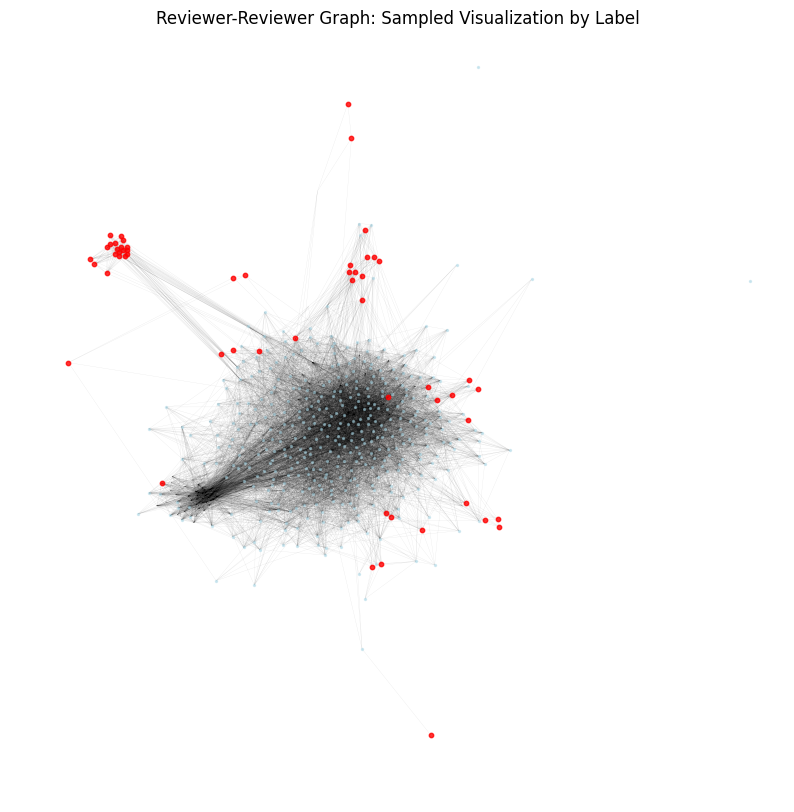

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Step 1: Sample the graph for visualization
# Take a sample subgraph (e.g., random 500 nodes) for easier visualization
sample_size = 500
sampled_nodes = random.sample(list(G.nodes), sample_size)
subgraph = G.subgraph(sampled_nodes)

# Step 2: Define color mapping based on `label`
label_colors = {
    0: 'lightblue',      # Fake reviewers with label 0
    1: 'red',   # Fake reviewers with label 1
    -10: 'gray'    # Unlabeled reviewers with label -10
}
node_colors = [label_colors.get(subgraph.nodes[node]['label'], 'gray') for node in subgraph.nodes]

# Step 3: Plot the subgraph with node colors
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph, seed=42, k=0.3)  # Use spring layout for better separation

label_0_nodes = [node for node in subgraph if subgraph.nodes[node]['label'] == 0]
label_1_nodes = [node for node in subgraph if subgraph.nodes[node]['label'] == 1]
label_minus_10_nodes = [node for node in subgraph if subgraph.nodes[node]['label'] == -10]

nx.draw_networkx_nodes(subgraph, pos, nodelist=label_0_nodes, node_color='lightblue', node_size=2, alpha=0.5)
nx.draw_networkx_nodes(subgraph, pos, nodelist=label_1_nodes, node_color='red', node_size=10, alpha=0.8)
#nx.draw_networkx_nodes(subgraph, pos, nodelist=label_minus_10_nodes, node_color='gray', node_size=2, alpha=0.5)

#nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=10, alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.1, width=0.2)
plt.title("Reviewer-Reviewer Graph: Sampled Visualization by Label")
plt.axis("off")
plt.show()


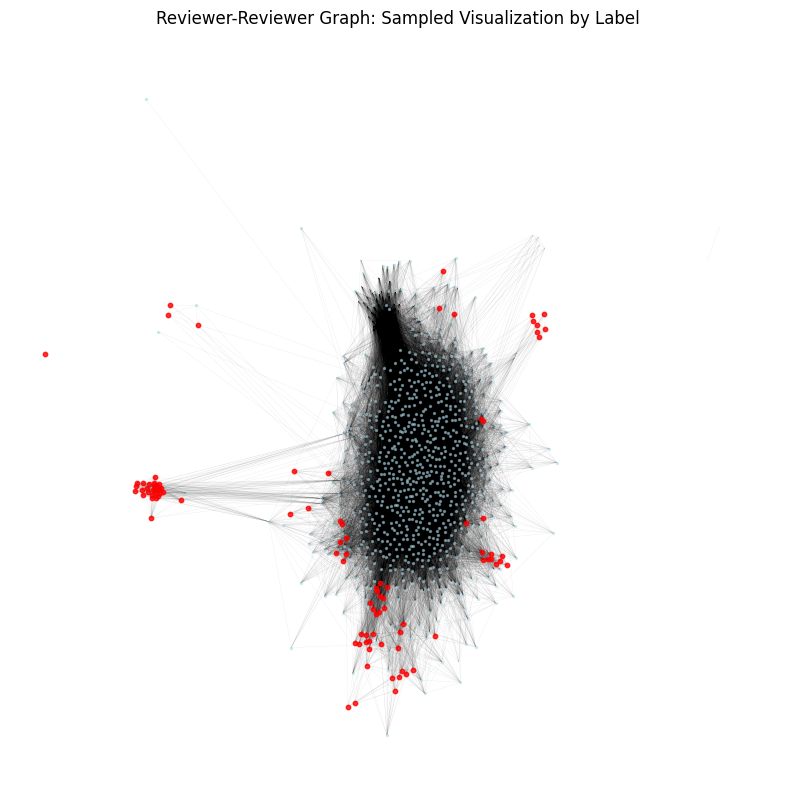

In [71]:
#similarly, sample 1000 nodes from the graph -->

# Step 1: Sample the graph for visualization
# Take a sample subgraph (e.g., random 500 nodes) for easier visualization
sample_size = 1000
sampled_nodes = random.sample(list(G.nodes), sample_size)
subgraph = G.subgraph(sampled_nodes)

# Step 2: Define color mapping based on `label`
label_colors = {
    0: 'lightblue',      # Fake reviewers with label 0
    1: 'red',   # Fake reviewers with label 1
    -10: 'gray'    # Unlabeled reviewers with label -10
}
node_colors = [label_colors.get(subgraph.nodes[node]['label'], 'gray') for node in subgraph.nodes]

# Step 3: Plot the subgraph with node colors
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph, seed=42, k=0.3)  # Use spring layout for better separation

label_0_nodes = [node for node in subgraph if subgraph.nodes[node]['label'] == 0]
label_1_nodes = [node for node in subgraph if subgraph.nodes[node]['label'] == 1]
label_minus_10_nodes = [node for node in subgraph if subgraph.nodes[node]['label'] == -10]

nx.draw_networkx_nodes(subgraph, pos, nodelist=label_0_nodes, node_color='lightblue', node_size=2, alpha=0.5)
nx.draw_networkx_nodes(subgraph, pos, nodelist=label_1_nodes, node_color='red', node_size=10, alpha=0.8)
#nx.draw_networkx_nodes(subgraph, pos, nodelist=label_minus_10_nodes, node_color='gray', node_size=2, alpha=0.5)

#nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=10, alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.1, width=0.2)
plt.title("Reviewer-Reviewer Graph: Sampled Visualization by Label")
plt.axis("off")
plt.show()


The maximum k-core number in the graph is: 651


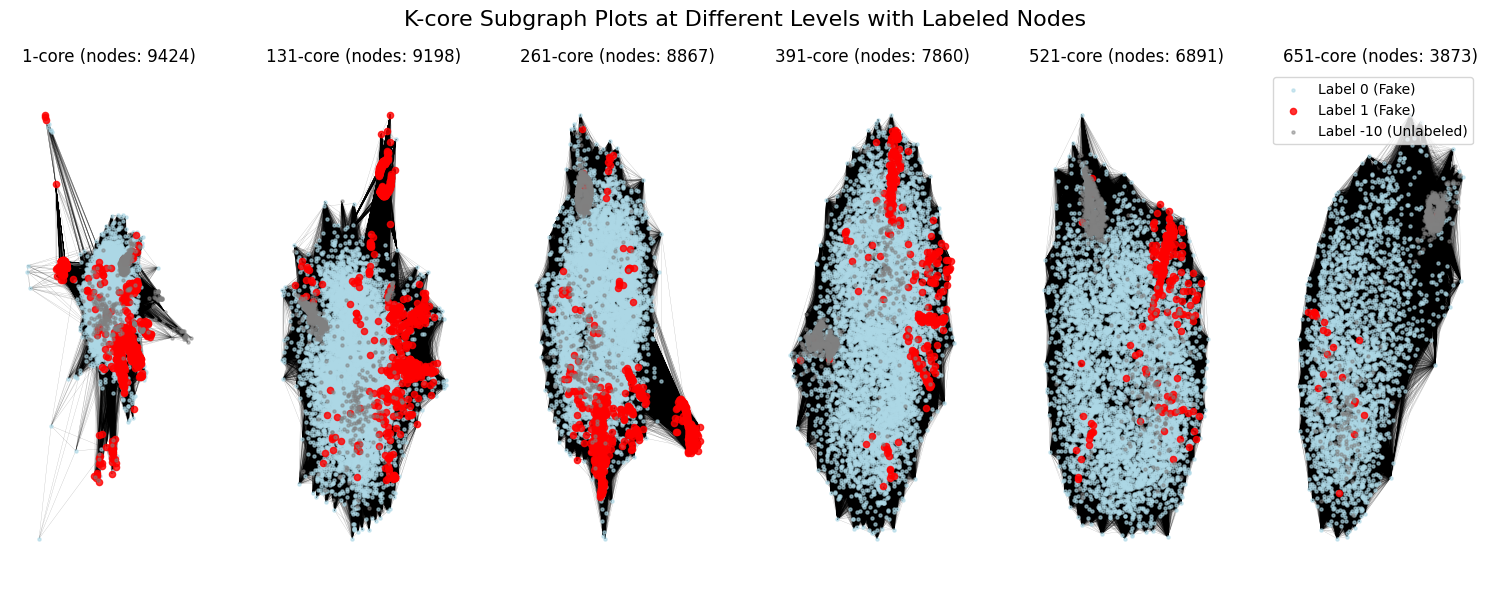

In [72]:
import networkx as nx
import matplotlib.pyplot as plt

# Calculate k-core numbers for each node
core_numbers = nx.core_number(G)
max_core = max(core_numbers.values())
print(f"The maximum k-core number in the graph is: {max_core}")

# Define the number of core levels to plot (adjust as necessary)
num_cores_to_plot = 5
core_levels = range(1, max_core + 1, max(1, max_core // num_cores_to_plot))

# Set up the plot grid
fig, axes = plt.subplots(1, len(core_levels), figsize=(15, 6))

# Plot each k-core level with labeled nodes
for ax, k in zip(axes, core_levels):
    # Extract the k-core subgraph
    k_core_subgraph = nx.k_core(G, k=k)
    pos = nx.spring_layout(k_core_subgraph, seed=42)  # Layout for visualization

    # Separate nodes by label
    label_0_nodes = [node for node in k_core_subgraph if k_core_subgraph.nodes[node].get('label') == 0]
    label_1_nodes = [node for node in k_core_subgraph if k_core_subgraph.nodes[node].get('label') == 1]
    label_minus_10_nodes = [node for node in k_core_subgraph if k_core_subgraph.nodes[node].get('label') == -10]

    # Draw nodes with different colors and sizes based on their labels
    nx.draw_networkx_nodes(k_core_subgraph, pos, nodelist=label_0_nodes, node_color='lightblue', node_size=5, alpha=0.6, ax=ax, label="Label 0")
    nx.draw_networkx_nodes(k_core_subgraph, pos, nodelist=label_1_nodes, node_color='red', node_size=20, alpha=0.8, ax=ax, label="Label 1")
    nx.draw_networkx_nodes(k_core_subgraph, pos, nodelist=label_minus_10_nodes, node_color='gray', node_size=5, alpha=0.5, ax=ax, label="Label -10")

    # Draw edges with reduced opacity for better readability
    nx.draw_networkx_edges(k_core_subgraph, pos, ax=ax, alpha=0.3, width=0.2)

    # Set title and turn off axis for each subplot
    ax.set_title(f"{k}-core (nodes: {len(k_core_subgraph.nodes())})")
    ax.axis("off")

# Add a legend for the colors
plt.legend(["Label 0 (Fake)", "Label 1 (Fake)", "Label -10 (Unlabeled)"], loc='upper right')
plt.suptitle("K-core Subgraph Plots at Different Levels with Labeled Nodes", fontsize=16)
plt.tight_layout()
plt.show()


Graph with different labels

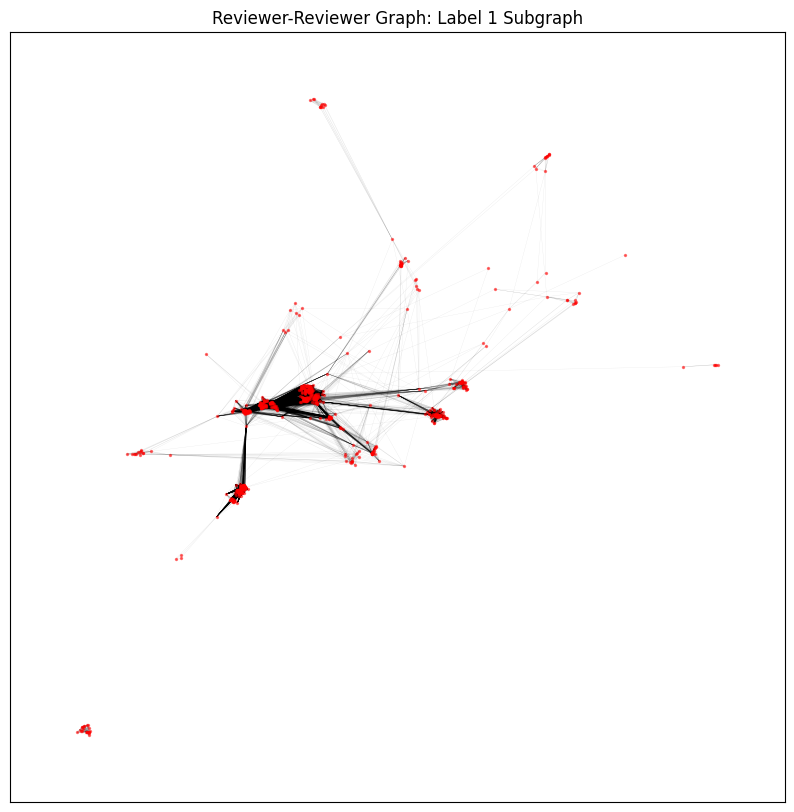

In [96]:
#label = 1
label_1_nodes = [node for node in G if G.nodes[node].get('label') == 1]
label_1_subgraph = G.subgraph(label_1_nodes)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(label_1_subgraph, seed=42)  # Layout for visualization
nx.draw_networkx_nodes(label_1_subgraph, pos, node_color='red', node_size=2, alpha=0.5)
nx.draw_networkx_edges(label_1_subgraph, pos, alpha=0.1, width=0.2)
plt.title("Reviewer-Reviewer Graph: Label 1 Subgraph")
plt.show()

In [107]:
summary_subgraph(label_1_subgraph)

Summary of Subgraph:
Number of nodes: 985
Number of edges: 91407
Average degree: 185.60
Max degree: 393
Max core number: 306
Clustering coefficient: 0.9187
Modularity: 0.3376
Number of connected components: 2
Number of triangles: 7438266


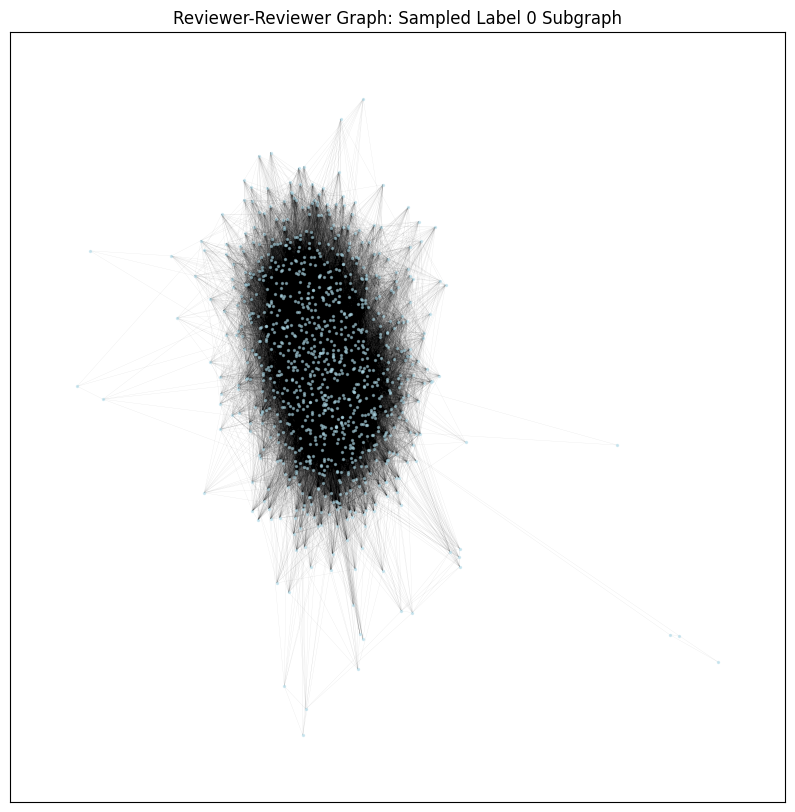

In [97]:
#sample same number of label 0 nodes
label_0_nodes = [node for node in G if G.nodes[node].get('label') == 0]
label_0_nodes = random.sample(label_0_nodes, len(label_1_nodes))
label_0_subgraph = G.subgraph(label_0_nodes)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(label_0_subgraph, seed=42)  # Layout for visualization
nx.draw_networkx_nodes(label_0_subgraph, pos, node_color='lightblue', node_size=2, alpha=0.5)
nx.draw_networkx_edges(label_0_subgraph, pos, alpha=0.1, width=0.2)
plt.title("Reviewer-Reviewer Graph: Sampled Label 0 Subgraph")
plt.show()

In [102]:
summary_subgraph(label_0_subgraph)

Summary of Label 1 Subgraph:
Number of nodes: 985
Number of edges: 58767
Average degree: 119.32
Max degree: 487
Max core number: 75
Clustering coefficient: 0.3162
Modularity: 0.2635
Number of connected components: 1
Number of triangles: 897701


## Subgroups among fake reviewers

Number of communities detected: 13


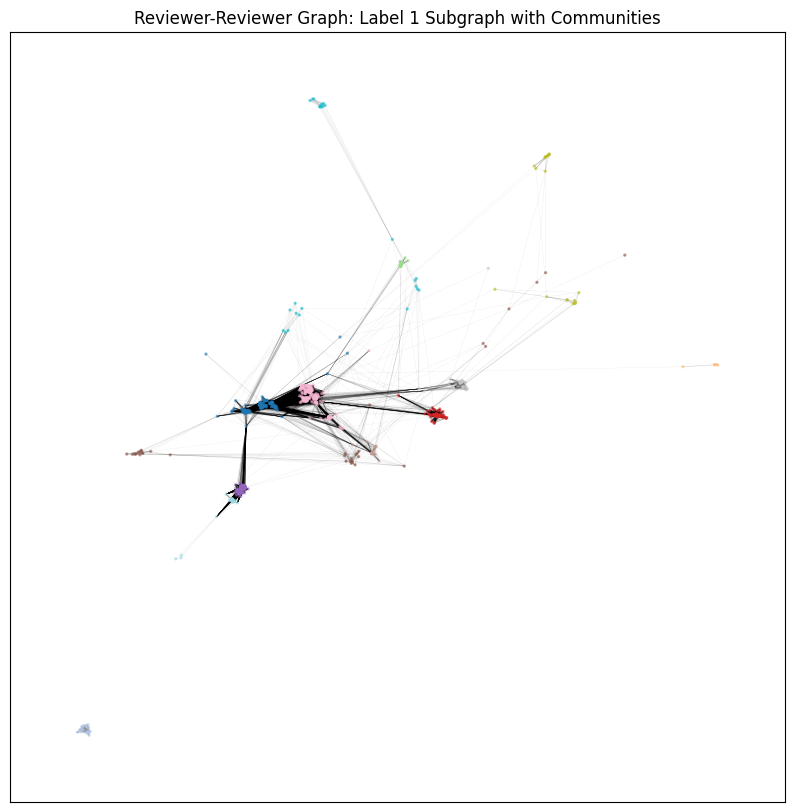

In [124]:
# louvain community detection
partition = community_louvain.best_partition(label_1_subgraph)
num_communities = max(partition.values()) + 1
print(f"Number of communities detected: {num_communities}")
cmap = plt.get_cmap("tab20", num_communities)
node_colors = [cmap(partition[node]) for node in label_1_subgraph.nodes]
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(label_1_subgraph, seed=42)  # Layout for visualization
nx.draw_networkx_nodes(label_1_subgraph, pos, node_color=node_colors, node_size=2, alpha=0.5)
nx.draw_networkx_edges(label_1_subgraph, pos, alpha=0.1, width=0.2)
plt.title("Reviewer-Reviewer Graph: Label 1 Subgraph with Communities")
plt.show()

Top 5 communities by size:
Community 5: 307 nodes
nodes in community:
[1163675648, 1348900878, 1337106458, 1292881958, 1142059048, 1310375978, 1271726138, 1272743998, 1157146688, 1323558978] ...


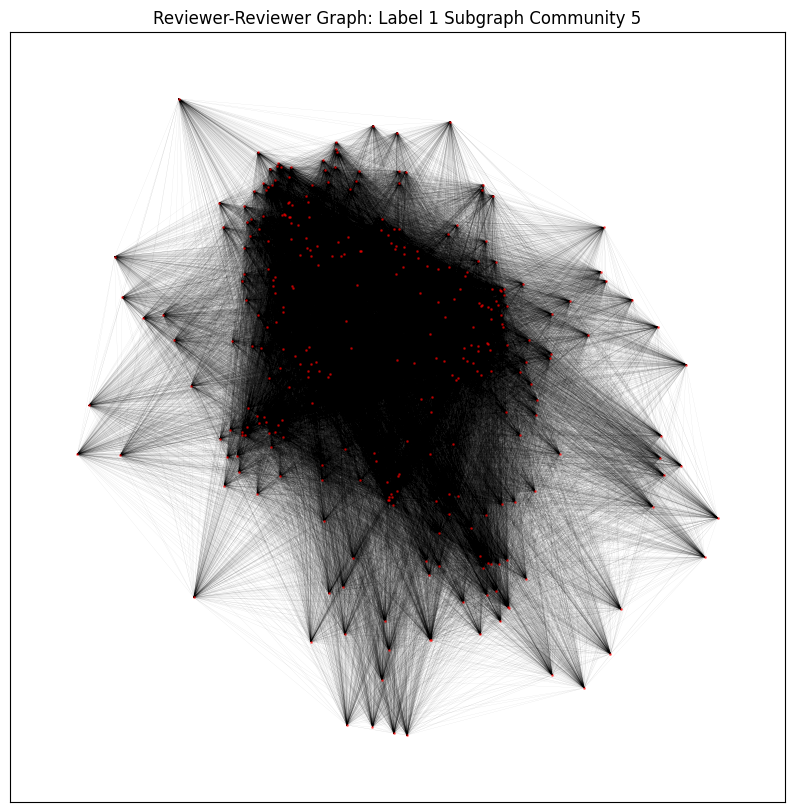

Community 8: 228 nodes
nodes in community:
[1107759108, 1104623628, 1091387428, 1046652968, 1104533548, 1112612908, 1046650928, 1104535608, 1107761208, 1047328828] ...


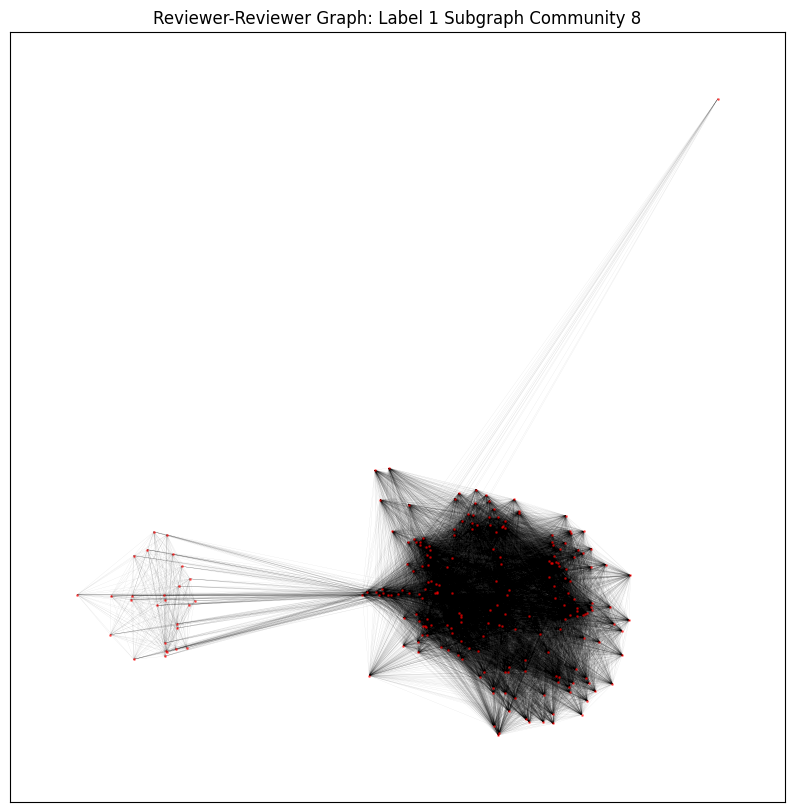

Community 0: 145 nodes
nodes in community:
[1027176448, 1038071808, 1054695428, 1065949208, 1057970268, 1054738528, 1237489798, 1289109658, 1239459998, 1239457978] ...


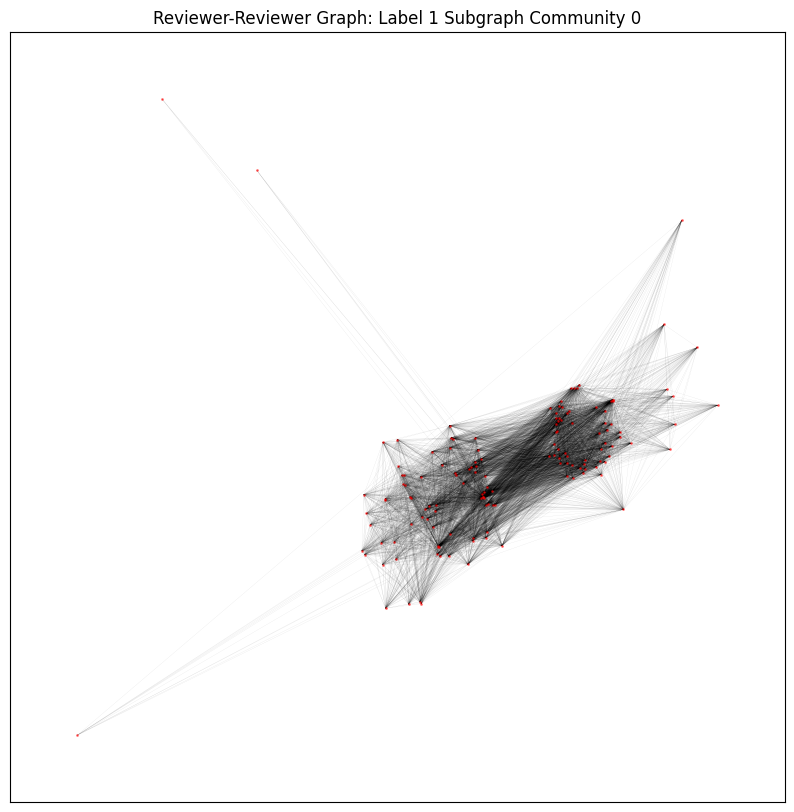

Community 4: 90 nodes
nodes in community:
[1041879048, 1035257868, 1065433108, 1041866788, 1035255848, 1017008178, 1041881148, 1103663168, 1065648208, 1041879128] ...


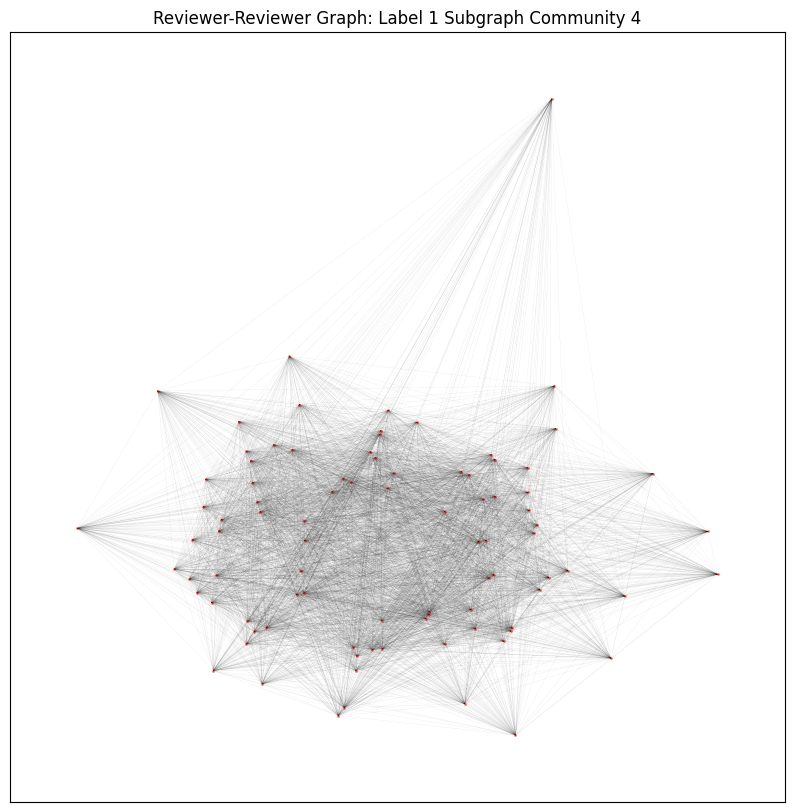

Community 6: 36 nodes
nodes in community:
[1039566868, 1284636918, 1249110298, 1302759738, 1031852388, 1039561088, 1039516108, 1180035538, 1033456238, 1043346068] ...


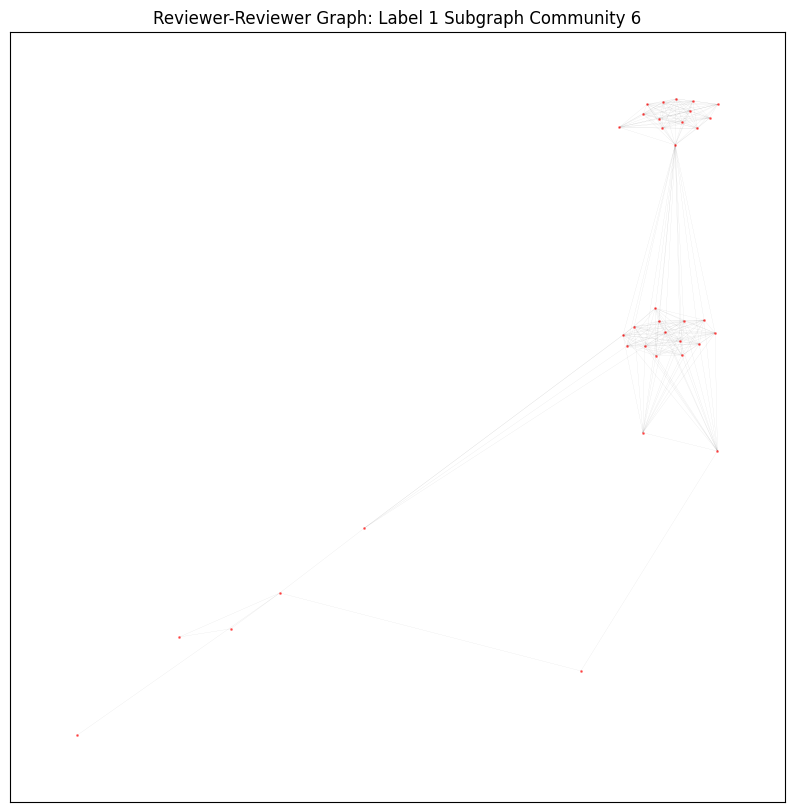

In [125]:
#communities
from collections import Counter
community_counts = Counter(partition.values())
top5_communities = community_counts.most_common(5)
print("Top 5 communities by size:")
for i, (community, count) in enumerate(top5_communities, 1):
    print(f"Community {community}: {count} nodes")
    plt.figure(figsize=(10, 10))
    nodes_in_community = [node for node, comm in partition.items() if comm == community]
    print("nodes in community:")
    print(nodes_in_community[:10],'...')
    subgraph = label_1_subgraph.subgraph(nodes_in_community)
    pos = nx.spring_layout(subgraph, seed=42) 
    nx.draw_networkx_nodes(subgraph, pos, node_color='red', node_size=1, alpha=0.5)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2, width=0.1)
    plt.title(f"Reviewer-Reviewer Graph: Label 1 Subgraph Community {community}")
    plt.show()

Number of communities detected: 9


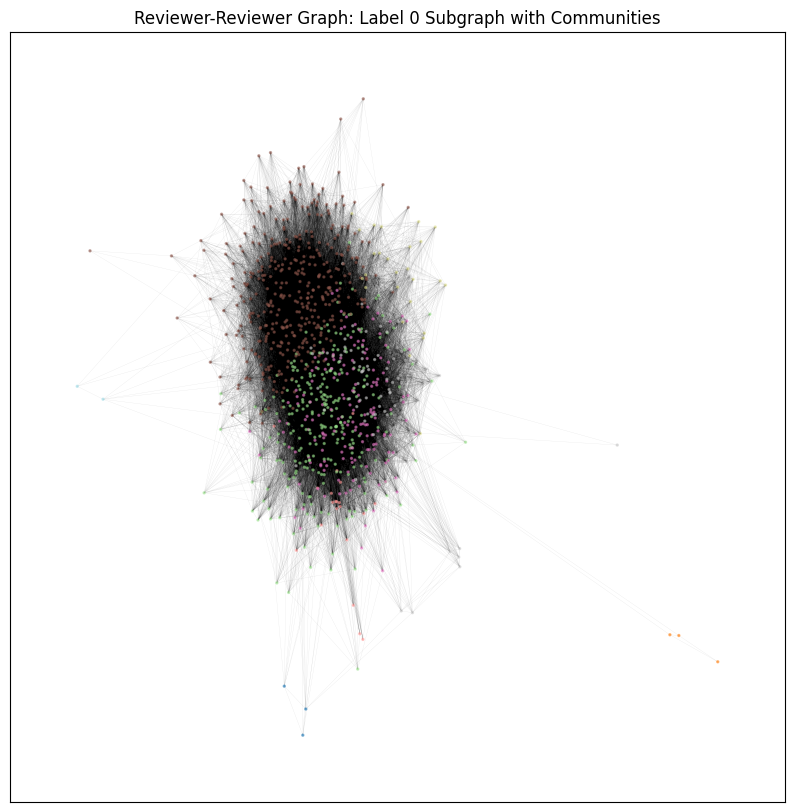

In [126]:
#label0 subgraph
partition = community_louvain.best_partition(label_0_subgraph)
num_communities = max(partition.values()) + 1
print(f"Number of communities detected: {num_communities}")
cmap = plt.get_cmap("tab20", num_communities)
node_colors = [cmap(partition[node]) for node in label_0_subgraph.nodes]
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(label_0_subgraph, seed=42)  # Layout for visualization
nx.draw_networkx_nodes(label_0_subgraph, pos, node_color=node_colors, node_size=2, alpha=0.5)
nx.draw_networkx_edges(label_0_subgraph, pos, alpha=0.1, width=0.2)
plt.title("Reviewer-Reviewer Graph: Label 0 Subgraph with Communities")
plt.show()

Show top 5 communities in the label 1 subgraph

Top 5 communities by size:
Community 4: 396 nodes
nodes in community:
[1185980418, 1278410758, 1008097288, 1160382478, 1001426958, 1072986128, 1042483218, 1046765588, 1161803798, 1139388458] ...


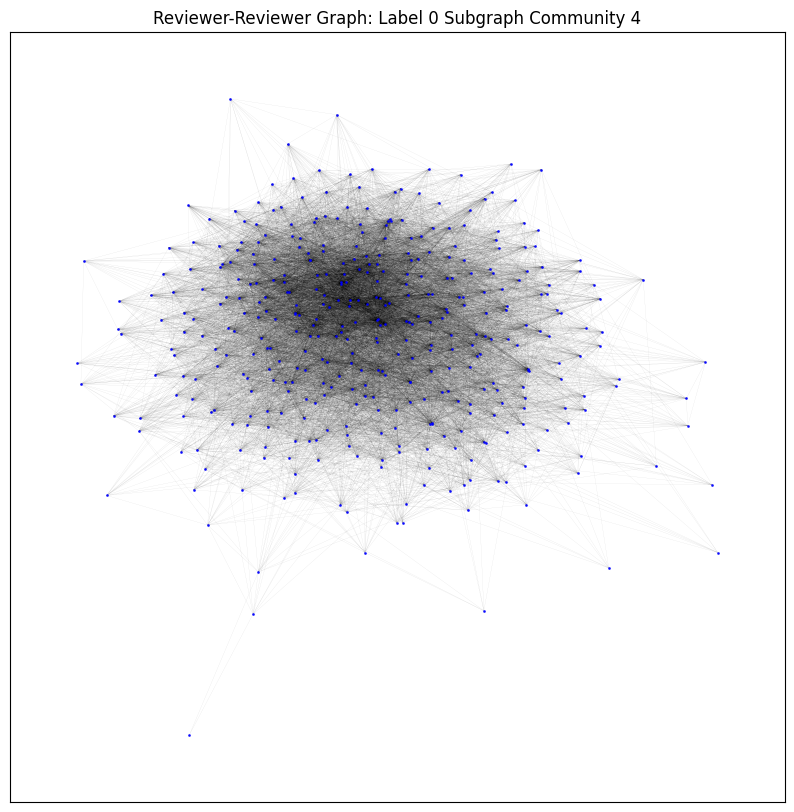

Community 2: 275 nodes
nodes in community:
[1017745428, 1230852118, 1051930648, 1215070238, 1005387808, 1074808868, 1128028198, 1036212268, 1038446638, 1120585778] ...


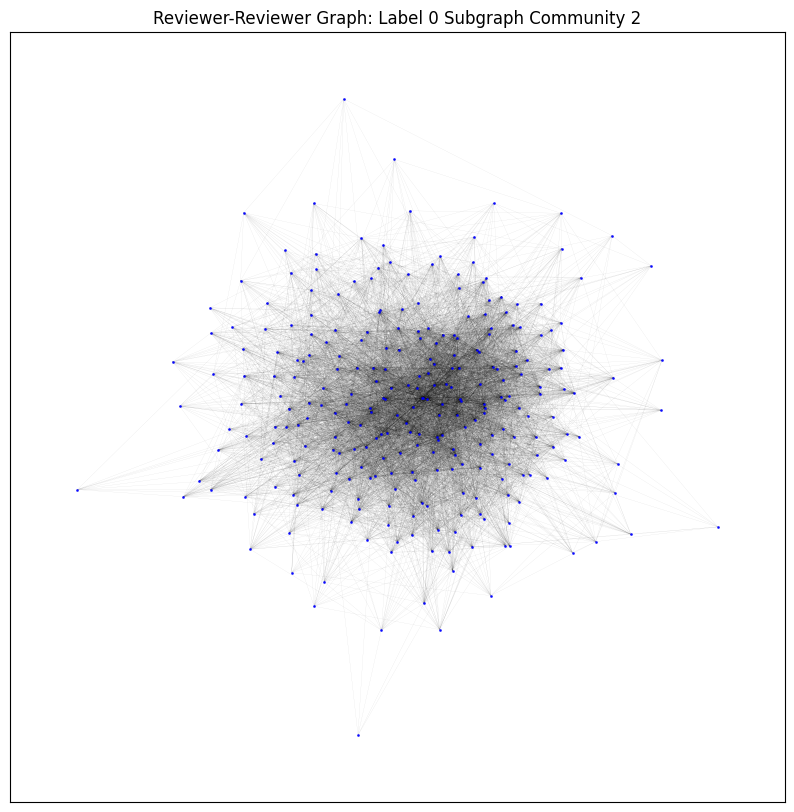

Community 5: 170 nodes
nodes in community:
[1196709918, 1207670818, 1173985318, 1196488758, 1144633398, 1094651958, 1148467278, 1112281178, 1218166878, 1188632678] ...


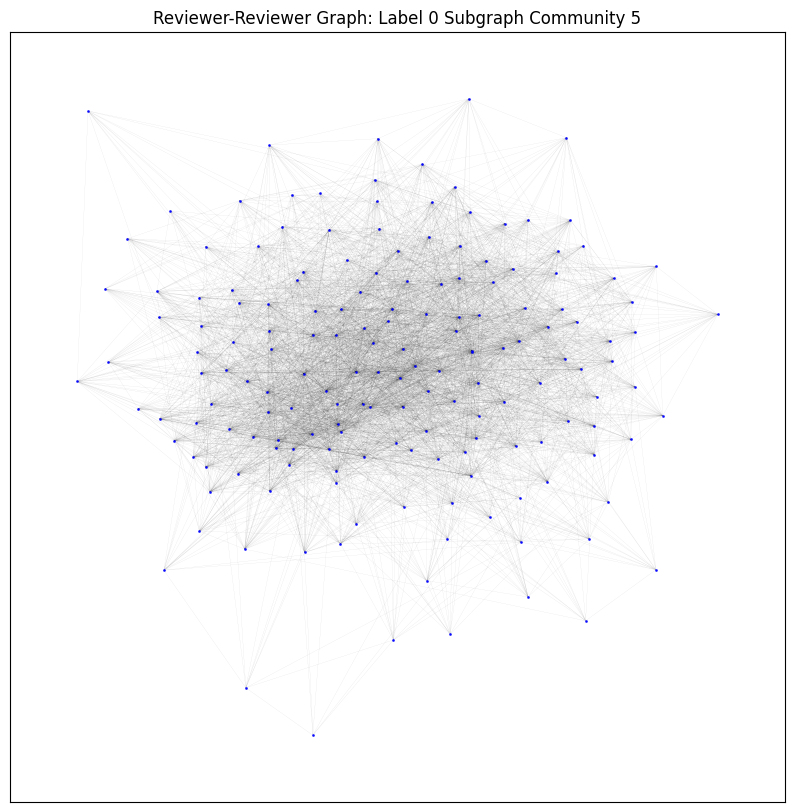

Community 6: 90 nodes
nodes in community:
[1000198178, 1123229738, 1047633988, 1170014278, 1149081678, 1220395098, 1239464098, 1120219318, 1083863238, 1178464458] ...


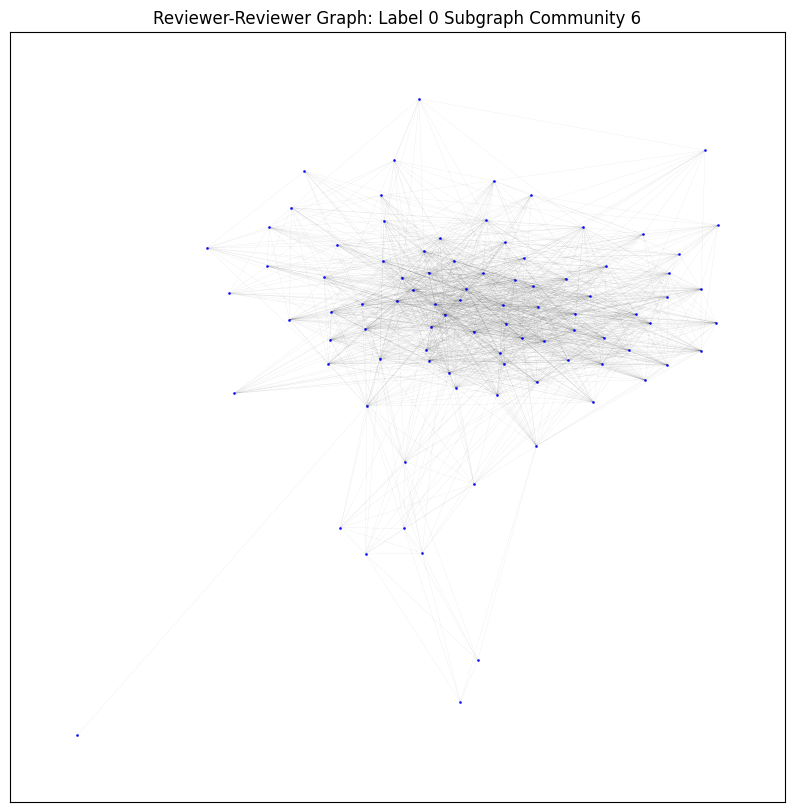

Community 7: 26 nodes
nodes in community:
[1155883018, 1089984538, 1163397238, 1128001778, 1057218868, 1159283018, 1017176398, 1198672398, 1081192978, 1004167718] ...


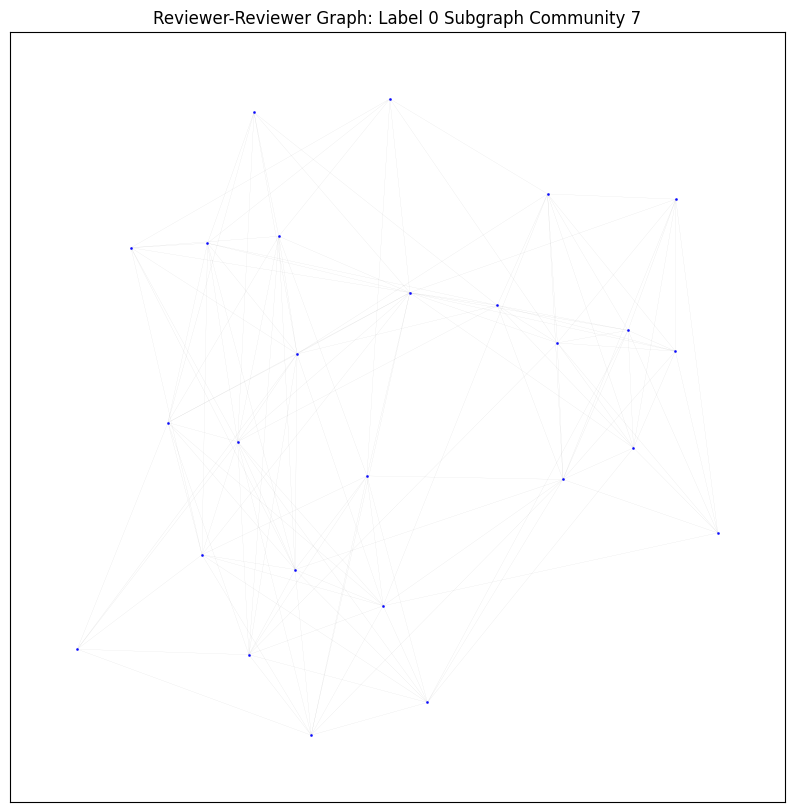

In [127]:
from collections import Counter
community_counts = Counter(partition.values())
top5_communities = community_counts.most_common(5)
print("Top 5 communities by size:")
for i, (community, count) in enumerate(top5_communities, 1):
    print(f"Community {community}: {count} nodes")
    plt.figure(figsize=(10, 10))
    nodes_in_community = [node for node, comm in partition.items() if comm == community]
    print("nodes in community:")
    print(nodes_in_community[:10],'...')
    subgraph = label_0_subgraph.subgraph(nodes_in_community)
    pos = nx.spring_layout(subgraph, seed=42) 
    nx.draw_networkx_nodes(subgraph, pos, node_color='blue', node_size=1, alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2, width=0.1)
    plt.title(f"Reviewer-Reviewer Graph: Label 0 Subgraph Community {community}")
    plt.show()

In [ ]:
#in contrast,
community_counts = Counter(partition.values())

# Examples

In [129]:
#extract 3 core nodes in the largest community of label 1
partition = community_louvain.best_partition(label_1_subgraph)
community_counts = Counter(partition.values())
largest_community = community_counts.most_common(1)[0][0]
core_nodes = [node for node, core in core_numbers.items() if partition[node] == largest_community]
subgraph_largest_community = label_1_subgraph.subgraph(core_nodes)
degree_centrality = nx.degree_centrality(subgraph_largest_community)
betweenness_centrality = nx.betweenness_centrality(subgraph_largest_community)
closeness_centrality = nx.closeness_centrality(subgraph_largest_community)


Top 3 nodes by degree centrality:
Node 1163675648: 1.0000
Node 1348900878: 1.0000
Node 1337106458: 1.0000


In [149]:
#sort the nodes by degree centrality
sorted_nodes_by_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top3_nodes_by_degree = sorted_nodes_by_degree[:3]
print("Top 3 nodes:")
for i, (node, centrality) in enumerate(top3_nodes_by_degree, 1):
    print(f"Node {node}: {centrality:.4f}")

# #sort the nodes by betweenness centrality
# sorted_nodes_by_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
# top3_nodes_by_betweenness = sorted_nodes_by_betweenness[:3]
# print("Top 3 nodes by betweenness centrality:")
# for i, (node, centrality) in enumerate(top3_nodes_by_betweenness, 1):
#     print(f"Node {node}: {centrality:.4f}")

#sort the nodes by closeness centrality
# sorted_nodes_by_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
# top3_nodes_by_closeness = sorted_nodes_by_closeness[:3]
# print("Top 3 nodes by closeness centrality:")
# for i, (node, centrality) in enumerate(top3_nodes_by_closeness, 1):
#     print(f"Node {node}: {centrality:.4f}")



Top 3 nodes:
Node 1163675648: 1.0000
Node 1348900878: 1.0000
Node 1337106458: 1.0000


In [137]:
eg_dfs = {}
for i, (node,_) in enumerate(top3_nodes_by_degree):
    eg = df[df['User_ID'] == node].sort_values(by='Date')
    eg_dfs[i] = eg
    eg.to_csv(f'../data/processed/fake_reviewer_eg_{i}.csv', index=False)

eg1 = eg_dfs[0]
eg2 = eg_dfs[1]
eg3 = eg_dfs[2]

In [139]:
print(len(eg1.Product_ID.unique()), len(eg2.Product_ID.unique()), len(eg3.Product_ID.unique()))
#common products:
common_products = set(eg1.Product_ID.unique()).intersection(set(eg2.Product_ID.unique()), set(eg3.Product_ID.unique()))
print(f"Number of common products: {len(common_products)}")

98 33 39
Number of common products: 21


In [154]:
ls = random.sample(list(common_products),5)
for table in [eg1, eg2, eg3]:
    display(table[table['Product_ID'].isin(ls)].sort_values(by='Product_ID'))

Product_ID     User_ID  Transaction_ID       Date  Rating  \
279712  B005Q6O81A  1163675648      1057475312 2011-10-25       5   
279714  B005TYBQ00  1163675648      1057491992 2011-10-25       5   
279718  B005TYBQIW  1163675648      1057897432 2011-10-30       5   
279719  B005TYBQL4  1163675648      1057477672 2011-10-25       5   
279727  B005UIRD52  1163675648      1057480812 2011-10-25       5   

                 Comment     user_ID  user_no  label       MNR  ANR       NDR  \
279712            自我中心 N  1163675648     6102      1  0.064072  0.2  0.016603   
279714           很多小故事 N  1163675648     6102      1  0.064072  0.2  0.016603   
279718  爱撒娇的女人，才会招来别人疼 N  1163675648     6102      1  0.064072  0.2  0.016603   
279719     维生素对宝宝的益智作用 N  1163675648     6102      1  0.064072  0.2  0.016603   
279727             很喜欢 N  1163675648     6102      1  0.064072  0.2  0.016603   

             BST       ENR   MeanVar       TMF  PopRank    DisAvg    CatEnt  
279712  0.001571  0.653897  0.072819  0.000174  0.01087  0.653285  0.077255  
279714  0.001571  0.653897  0.072819  0.000174  0.01087  0.653285  0.077255  
279718  0.001571  0.653897  0.072819  0.000174  0.01087  0.653285  0.077255  
279719  0.001571  0.653897  0.072819  0.000174  0.01087  0.653285  0.077255  
279727  0.001571  0.653897  0.072819  0.000174  0.01087  0.653285  0.077255

Product_ID     User_ID  Transaction_ID       Date  Rating  \
468911  B005Q6O81A  1348900878      1058725062 2011-10-11       5   
468913  B005TYBQ00  1348900878      1058734602 2011-10-11       5   
468917  B005TYBQIW  1348900878      1058912052 2011-12-11       5   
468918  B005TYBQL4  1348900878      1058724082 2011-10-11       5   
468925  B005UIRD52  1348900878      1058727502 2011-10-11       5   

              Comment     user_ID  user_no  label       MNR       ANR  \
468911       做对人做对事 N  1348900878     9407      1  0.023828  0.032558   
468913         细细体会 N  1348900878     9407      1  0.023828  0.032558   
468917  给恋爱中的女人一个提示 N  1348900878     9407      1  0.023828  0.032558   
468918     科学益智指导书。 N  1348900878     9407      1  0.023828  0.032558   
468925        优雅，享受 N  1348900878     9407      1  0.023828  0.032558   

             NDR       BST       ENR   MeanVar       TMF  PopRank    DisAvg  \
468911  0.016603  0.003997  0.309115  0.250314  0.000015  0.01087  0.665239   
468913  0.016603  0.003997  0.309115  0.250314  0.000015  0.01087  0.665239   
468917  0.016603  0.003997  0.309115  0.250314  0.000015  0.01087  0.665239   
468918  0.016603  0.003997  0.309115  0.250314  0.000015  0.01087  0.665239   
468925  0.016603  0.003997  0.309115  0.250314  0.000015  0.01087  0.665239   

          CatEnt  
468911  0.324898  
468913  0.324898  
468917  0.324898  
468918  0.324898  
468925  0.324898

Product_ID     User_ID  Transaction_ID       Date  Rating  \
467719  B005Q6O81A  1337106458      1058360042 2011-04-11       5   
467721  B005TYBQ00  1337106458      1058492292 2011-06-11       5   
467725  B005TYBQIW  1337106458      1058666072 2011-09-11       5   
467726  B005TYBQL4  1337106458      1058360292 2011-04-11       5   
467733  B005UIRD52  1337106458      1058340142 2011-04-11       5   

              Comment     user_ID  user_no  label       MNR       ANR  \
467719  让自己获得更好的知识！ N  1337106458     9374      1  0.029653  0.069767   
467721          全买了 N  1337106458     9374      1  0.029653  0.069767   
467725            好 N  1337106458     9374      1  0.029653  0.069767   
467726          挺好的 N  1337106458     9374      1  0.029653  0.069767   
467733         质量很好 N  1337106458     9374      1  0.029653  0.069767   

             NDR       BST       ENR  MeanVar       TMF  PopRank    DisAvg  \
467719  0.011494  0.001839  0.449141  0.24941  0.000095  0.01087  0.679107   
467721  0.011494  0.001839  0.449141  0.24941  0.000095  0.01087  0.679107   
467725  0.011494  0.001839  0.449141  0.24941  0.000095  0.01087  0.679107   
467726  0.011494  0.001839  0.449141  0.24941  0.000095  0.01087  0.679107   
467733  0.011494  0.001839  0.449141  0.24941  0.000095  0.01087  0.679107   

          CatEnt  
467719  0.274021  
467721  0.274021  
467725  0.274021  
467726  0.274021  
467733  0.274021

# Summary Statistics

In [89]:
df_node = df[['User_ID','label','MNR','ANR','NDR','BST','ENR','MeanVar','TMF','PopRank','DisAvg','CatEnt']].groupby('User_ID').mean()

In [88]:
summary_1

count      mean       std       min       25%       50%       75%  \
label    985.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
MNR      985.0  0.144715  0.084647  0.000000  0.077310  0.136616  0.193805   
ANR      985.0  0.183643  0.139420  0.000000  0.074419  0.158140  0.283721   
NDR      985.0  0.014693  0.019806  0.000000  0.005109  0.011494  0.017880   
BST      985.0  0.003018  0.006666  0.000000  0.000434  0.001213  0.002554   
ENR      985.0  0.575700  0.214557  0.000000  0.449141  0.653897  0.718626   
MeanVar  985.0  0.093267  0.089767  0.000000  0.000000  0.074511  0.139926   
TMF      985.0  0.032492  0.048274  0.000000  0.000723  0.022640  0.040248   
PopRank  985.0  0.027142  0.015375  0.000000  0.011122  0.025614  0.037399   
DisAvg   985.0  0.296762  0.225130  0.011944  0.118504  0.195983  0.568153   
CatEnt   985.0  0.552114  0.297009  0.001794  0.222400  0.675651  0.791255   

              max  
label    1.000000  
MNR      0.511517  
ANR      1.000000  
NDR      0.466156  
BST      0.136654  
ENR      1.000000  
MeanVar  0.785722  
TMF      0.760111  
PopRank  0.153846  
DisAvg   0.697855  
CatEnt   0.947310

In [81]:
summary_0

count      mean       std       min       25%       50%       75%  \
label    7389.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
MNR      7389.0  0.193203  0.117082  0.000000  0.109346  0.183479  0.262907   
ANR      7389.0  0.053895  0.052204  0.000000  0.023256  0.041861  0.069767   
NDR      7389.0  0.011568  0.009629  0.000000  0.005109  0.008940  0.015326   
BST      7389.0  0.003850  0.005380  0.000000  0.000958  0.002082  0.004342   
ENR      7389.0  0.372540  0.162492  0.000000  0.265522  0.383091  0.486129   
MeanVar  7389.0  0.425495  0.263894  0.000000  0.191709  0.458519  0.646946   
TMF      7389.0  0.181862  0.083997  0.000082  0.130184  0.172839  0.223788   
PopRank  7389.0  0.083165  0.051577  0.000000  0.062500  0.078125  0.095238   
DisAvg   7389.0  0.135965  0.071577  0.000000  0.088566  0.125312  0.170669   
CatEnt   7389.0  0.764608  0.084215  0.159470  0.718009  0.779027  0.827054   

              max  
label    0.000000  
MNR      1.000000  
ANR      0.669767  
NDR      0.068965  
BST      0.040869  
ENR      0.903567  
MeanVar  1.000000  
TMF      1.000000  
PopRank  1.000000  
DisAvg   0.719826  
CatEnt   0.933178

In [87]:
from spicy import stats

summary_0 = df_node[df_node['label'] == 0].describe().T
summary_1 = df_node[df_node['label'] == 1].describe().T
t_test = {}
for feature in summary_0.index:
    if feature != 'User_ID' and feature != 'label':
        t,p = stats.ttest_ind(df_node[df_node['label'] == 0][feature], df_node[df_node['label'] == 1][feature], equal_var=False)
        t_test[feature] = (t,p)
    else:
        t_test[feature] = (None, None)

summary = pd.DataFrame({
    'label 0': summary_0['mean'],
    'label 1': summary_1['mean'],
    't-statistic': [t for t,_ in t_test.values()],
    'p-value': [p for _,p in t_test.values()]
})

summary=summary.round(4)
summary

label 0  label 1  t-statistic  p-value
label     0.0000   1.0000          NaN      NaN
MNR       0.1932   0.1447      16.0477   0.0000
ANR       0.0539   0.1836     -28.9384   0.0000
NDR       0.0116   0.0147      -4.8753   0.0000
BST       0.0038   0.0030       3.7575   0.0002
ENR       0.3725   0.5757     -28.6428   0.0000
MeanVar   0.4255   0.0933      79.1792   0.0000
TMF       0.1819   0.0325      81.9681   0.0000
PopRank   0.0832   0.0271      72.3259   0.0000
DisAvg    0.1360   0.2968     -22.2667   0.0000
CatEnt    0.7646   0.5521      22.3347   0.0000